# Whole image quality control metric evaluation

In this notebook, we will use the outputted QC metrics to start working on developing thresholds using z-score to flag and skip images during CellProfiler illumination correction. These are currently not proven to be generalizable and will only be applied to one plate.

**Note**: We will be using Plate 4 measurements only. 

**Blur metric to detect out of focus images** -> PowerLogLogSlope

**Saturation metric to detect large smudges** -> PercentMaximal

## Import libraries

In [1]:
import pathlib
import pandas as pd

from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

## Set paths and load in data frame

In [2]:
# Directory for figures to be outputted
figure_dir = pathlib.Path("./qc_figures")
figure_dir.mkdir(exist_ok=True)

# Focus on Plate 4
plate = "localhost231120090001"

# Read in CSV with all image quality metrics per image
qc_df = pd.read_csv(pathlib.Path(f"./qc_results/{plate}/Image.csv"))

# Adding 'Metadata_Well' and 'Metadata_Site' columns using filename from FileName_OrigActin (same for all channels)
qc_df['Metadata_Well'] = qc_df['FileName_OrigActin'].str.extract(r'_(\w{3})\w*\.TIF')
qc_df['Metadata_Site'] = qc_df['FileName_OrigActin'].str.extract(r'_\w{3}(\w{3})\w*\.TIF')

print(qc_df.shape)
qc_df.head()

(960, 149)


,Channel_OrigActin,Channel_OrigDNA,Channel_OrigER,Channel_OrigMito,Channel_OrigPM,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05MeasureImageQuality,...,URL_OrigER,URL_OrigMito,URL_OrigPM,Width_OrigActin,Width_OrigDNA,Width_OrigER,Width_OrigMito,Width_OrigPM,Metadata_Well,Metadata_Site
0,-1,-1,-1,-1,-1,0.0,0.0,1.56,0.0,2.11,...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,1104,1104,1104,1104,1104,B02,f00
1,-1,-1,-1,-1,-1,0.0,0.0,1.08,0.0,2.05,...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,1104,1104,1104,1104,1104,B02,f01
2,-1,-1,-1,-1,-1,0.0,0.0,0.79,0.0,2.51,...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,1104,1104,1104,1104,1104,B02,f02
3,-1,-1,-1,-1,-1,0.0,0.0,0.52,0.0,2.01,...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,1104,1104,1104,1104,1104,B02,f03
4,-1,-1,-1,-1,-1,0.0,0.0,0.60,0.0,1.97,...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,file:/home/jenna/CFReT_data/0.download_data/Im...,1104,1104,1104,1104,1104,B02,f04


## Create concat dataframe combining blur and saturation metrics from all channels

In [3]:
# List of channels
channels = ["Actin", "DNA", "ER", "PM", "Mito"]

# Create DataFrames for each channel with all Metadata columns
Actin_df = qc_df.filter(like="Metadata_").drop(columns=["Metadata_Series", "Metadata_Frame"]).copy()
DNA_df = Actin_df.copy()
ER_df = Actin_df.copy()
PM_df = Actin_df.copy()
Mito_df = Actin_df.copy()

# Iterate through each channel and add the specified columns
for channel in channels:
    # Add PowerLogLogSlope column
    globals()[f"{channel}_df"][f"ImageQuality_PowerLogLogSlope_Orig{channel}"] = qc_df[
        f"ImageQuality_PowerLogLogSlope_Orig{channel}"
    ]

    # Add PercentMaximal column
    globals()[f"{channel}_df"][f"ImageQuality_PercentMaximal_Orig{channel}"] = qc_df[
        f"ImageQuality_PercentMaximal_Orig{channel}"
    ]

    # Rename columns for each channel to concat
    globals()[f"{channel}_df"] = globals()[f"{channel}_df"].rename(
        columns={
            f"ImageQuality_PowerLogLogSlope_Orig{channel}": "ImageQuality_PowerLogLogSlope",
            f"ImageQuality_PercentMaximal_Orig{channel}": f"ImageQuality_PercentMaximal"
        }
    )

    # Add "Channel" column
    globals()[f"{channel}_df"]["Channel"] = channel

# Concat the channel data frames together for plotting
df = pd.concat([Actin_df, DNA_df, ER_df, PM_df, Mito_df], ignore_index=True)

print(df.shape)
df.head()

(4800, 5)


,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel
0,B02,f00,-1.256993,0.000082,Actin
1,B02,f01,-1.366094,0.000082,Actin
2,B02,f02,-1.437336,0.000082,Actin
3,B02,f03,-1.220381,0.000082,Actin
4,B02,f04,-1.490232,0.000082,Actin


## Visualize blur metric

Based on the plot below, we can see the `actin` channel distribution is more different than the rest of the channels. We found that this difference is due to this channel on average being more dim, but not blurry. We decided that the DNA and PM channels were best at identifying blurry images and minimized removing good quality images. **We used the z-scoring method to identify max and min thresholds using 2 standard deviations.**

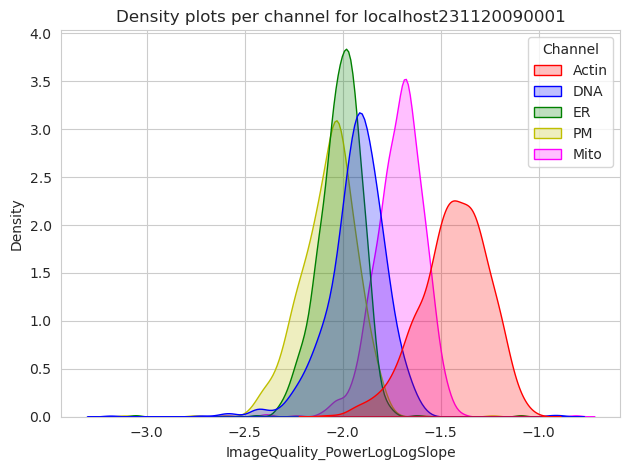

In [4]:
sns.set_style('whitegrid')
sns.kdeplot(data=df, x='ImageQuality_PowerLogLogSlope', hue='Channel', palette=['r', 'b', 'g', 'y', 'magenta'],fill=True, common_norm=False)
plt.title(f'Density plots per channel for {plate}')
plt.xlabel('ImageQuality_PowerLogLogSlope')
plt.ylabel('Density')

plt.tight_layout()
plt.savefig(pathlib.Path(f"{figure_dir}/{plate}_channels_blur_density.png"), dpi=500)
plt.show()

In [5]:
summary_statistics = df["ImageQuality_PowerLogLogSlope"].describe()
print(summary_statistics)

count    4800.000000
mean       -1.833436
std         0.275323
min        -3.182920
25%        -2.026610
50%        -1.888913
75%        -1.659077
max        -0.812236
Name: ImageQuality_PowerLogLogSlope, dtype: float64


In [6]:
# Calculate Z-scores for the column
z_scores = zscore(df['ImageQuality_PowerLogLogSlope'])

# Set a threshold for Z-scores (adjust as needed for number of standard deviations away from the mean)
threshold_z = 2

# Identify outlier rows based on Z-scores above and below the mean since we are using absolute values of the z-scores
blur_outliers = df[abs(z_scores) > threshold_z]

# Remove any blur outliers detected in for all channels (currently we have concluded DNA and PM channels are best able to detect blurry images)
blur_outliers = blur_outliers[(blur_outliers['Channel'] == 'DNA') | (blur_outliers['Channel'] == 'PM')]

print(blur_outliers.shape)
print(blur_outliers['Channel'].value_counts())
blur_outliers.sort_values(by='ImageQuality_PowerLogLogSlope', ascending=False).head()


(42, 5)
PM     26
DNA    16
Name: Channel, dtype: int64


,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel
1097,B10,f09,-0.890656,0.000082,DNA
1295,D02,f15,-0.940512,0.000082,DNA
3017,B10,f09,-1.236364,0.000082,PM
3132,C07,f12,-2.385826,0.042910,PM
3019,B10,f11,-2.385860,0.101984,PM


In [7]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PowerLogLogSlope"].mean()
std_dev = df["ImageQuality_PowerLogLogSlope"].std()

# Set the threshold multiplier for above and below the mean
threshold = 2

# Calculate the threshold values
threshold_value_above_mean = mean_value + threshold * std_dev
threshold_value_below_mean = mean_value - threshold * std_dev

# Print the calculated threshold values
print("Threshold for outliers above the mean:", threshold_value_above_mean)
print("Threshold for outliers below the mean:", threshold_value_below_mean)

Threshold for outliers above the mean: -1.2827898535807258
Threshold for outliers below the mean: -2.3840811649380393


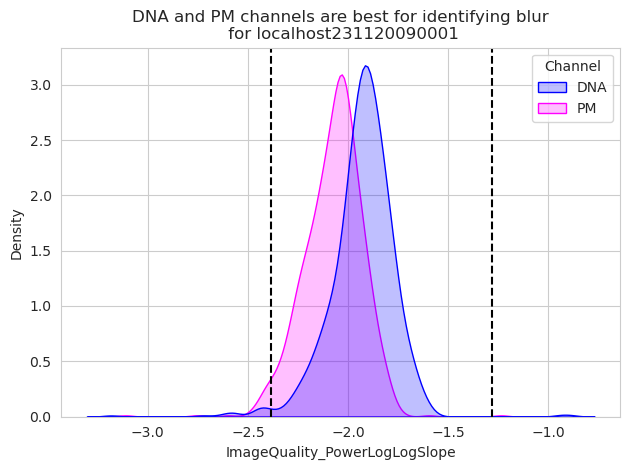

In [8]:
sns.set_style('whitegrid')
sns.kdeplot(data=df[df['Channel'].isin(['DNA', 'PM'])], x='ImageQuality_PowerLogLogSlope', hue='Channel', palette=['b', 'magenta'], fill=True, common_norm=False)
plt.title(f'DNA and PM channels are best for identifying blur\n for {plate}')
plt.xlabel('ImageQuality_PowerLogLogSlope')
plt.ylabel('Density')

plt.axvline(x=-1.2827898535807258, color='k', linestyle='--')
plt.axvline(x=-2.3840811649380393, color='k', linestyle='--')

plt.tight_layout()
plt.savefig(pathlib.Path(f"{figure_dir}/{plate}_DNA_PM_blur_density.png"), dpi=500)
plt.show()

## Saturation metric

For saturation metrics, we are looking for:

- Smudged images (usually seen in `DNA` channel regardless of stain)
- Specifically for the CFReT project, some cells will start clustering where they are overlapping, causing issues during segmentation. Based on the below threshold method, we can see that intensely clustered cells are easily identified in the `PM` channel.

This means that we will only be setting threshold for saturation outliers that are detected from the DNA and PM channels in the CellProfiler IC pipeline.

In [9]:
summary_statistics = df["ImageQuality_PercentMaximal"].describe()
print(summary_statistics)

count    4800.000000
mean        0.011794
std         0.127570
min         0.000082
25%         0.000082
50%         0.000082
75%         0.002872
max         4.589782
Name: ImageQuality_PercentMaximal, dtype: float64


In [10]:
# Calculate Z-scores for the column
z_scores = zscore(df['ImageQuality_PercentMaximal'])

# Set a threshold for Z-scores (adjust as needed for number of standard deviations away from the mean)
threshold_z = 2

# Identify outlier rows based on Z-scores greater than as to identify whole images with abnormally high saturated pixels
sat_outliers = df[abs(z_scores) > threshold_z]

# Remove any outliers detected in other channels (currently we have concluded that those other channels don't detect artifacts)
sat_outliers = sat_outliers[(sat_outliers['Channel'] == 'DNA') | (sat_outliers['Channel'] == 'PM')]

# Append saturation outliers to blur outliers, drop any duplicate FOVs and save outliers for QC report
outliers = pd.concat([sat_outliers, blur_outliers], ignore_index=True).drop_duplicates()

# Save outliers data frame to view in report
outliers.to_csv("./qc_results/qc_outliers.csv")

print(sat_outliers.shape)
print(sat_outliers['Channel'].value_counts())
sat_outliers.sort_values(by='ImageQuality_PercentMaximal', ascending=True).head()

(23, 5)
PM     14
DNA     9
Name: Channel, dtype: int64


,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope,ImageQuality_PercentMaximal,Channel
3428,E06,f04,-2.303739,0.281585,PM
1432,D11,f08,-2.174141,0.311122,DNA
3175,C10,f07,-2.039478,0.320311,PM
2969,B07,f09,-2.395427,0.337623,PM
3353,D11,f09,-2.324902,0.338115,PM


In [11]:
# Calculate the mean and standard deviation
mean_value = df["ImageQuality_PercentMaximal"].mean()
std_dev = df["ImageQuality_PercentMaximal"].std()

# Set the threshold multiplier for above and below the mean
threshold = 2

# Calculate the threshold values
threshold_value_above_mean = mean_value + threshold * std_dev

# Print the calculated threshold values
print("Threshold for outliers above the mean:", threshold_value_above_mean)

Threshold for outliers above the mean: 0.2669342845464116


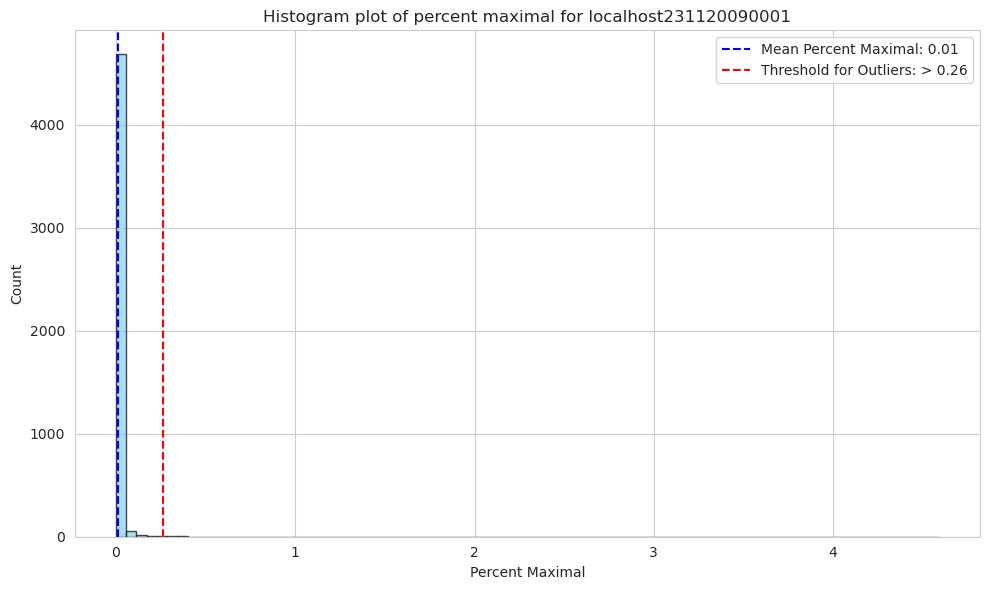

In [12]:
# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.hist(df['ImageQuality_PercentMaximal'], bins=80, color='skyblue', edgecolor='black', alpha=0.7)

# Add mean and threshold lines
plt.axvline(
    x=df["ImageQuality_PercentMaximal"].mean(),
    color="b",
    linestyle="--",
    label=f'Mean Percent Maximal: {df["ImageQuality_PercentMaximal"].mean():.2f}',
)
plt.axvline(
    x=0.26,
    color="r",
    linestyle="--",
    label='Threshold for Outliers: > 0.26',
)

# Set labels and title
plt.ylabel('Count')
plt.xlabel('Percent Maximal')
plt.title(f'Histogram plot of percent maximal for {plate}')
plt.legend()
plt.tight_layout()

plt.savefig(pathlib.Path(f"{figure_dir}/{plate}_percent_maximal.png"), dpi=500)

# Show the plot
plt.show()


### Zoomed-in plot

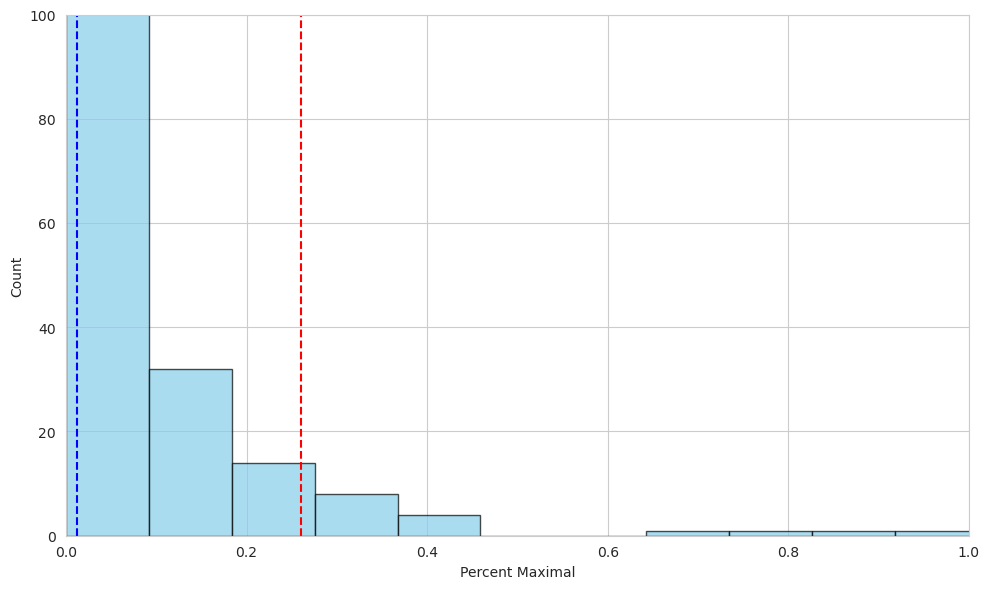

In [13]:
# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.hist(df['ImageQuality_PercentMaximal'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Add mean and threshold lines
plt.axvline(
    x=df["ImageQuality_PercentMaximal"].mean(),
    color="b",
    linestyle="--",
    label=f'Mean Percent Maximal: {df["ImageQuality_PercentMaximal"].mean():.2f}',
)
plt.axvline(
    x=0.26,
    color="r",
    linestyle="--",
    label='Threshold for Outliers: > 0.26',
)

# Set labels
plt.ylabel('Count')
plt.xlabel('Percent Maximal')

# Set the zoomed-in axis ranges
plt.xlim(0, 1)
plt.ylim(0, 100)

plt.tight_layout()

plt.savefig(pathlib.Path(f"{figure_dir}/{plate}_percent_maximal_zoomed.png"), dpi=500)

# Show the plot
plt.show()
